# RAISE the Bar: Restriction of Action Spaces for Improved Social Welfare and Equity in Traffic Management
## Sioux Falls experiment

In [1]:
import pandas as pd
import networkx as nx
import numpy as np

from src.traffic.v4.src.environment import build_network, create_cars, TrafficModel, Car


network_path = 'data/sf1_net.txt'
costs_path = 'data/sf1_c.txt'
cars_path = 'data/sf1_dem.txt'

In [2]:
def create_sioux_falls_network(network_path: str, costs_path: str, capacity=2, scaling: int = 60):
    net = pd.read_csv(network_path, sep='\s+', names=['init_node', 'term_node'],
                      index_col=False)
    n = nx.DiGraph([(edge['init_node'], edge['term_node']) for index, edge in net.iterrows()])

    c = pd.read_csv(costs_path,
                    sep='\s+',
                    names=['free_flow', 'b', 'capacity', 'power'],
                    index_col=False)
    nx.set_edge_attributes(
        n,
        {
            (int(net[net.index == i]['init_node'].iloc[0]),
             int(net[net.index == i]['term_node'].iloc[0])): (scaling * edge['free_flow'],
                                                               scaling * edge['free_flow'] * edge['b'] * 10000
                                                              / (edge['capacity'] ** edge['power']),
                                                              capacity,
                                                              1) for i, edge in c.iterrows()
        },
        "latency_params",
    )

    return build_network(n)

In [3]:
def create_sioux_falls_cars(path, network, max_steps, scaling: int = 10, seed=42):
    trips = pd.read_csv(path, sep=' ', names=['s', 't', 'cars'], index_col=False)
    routes = {(trip['s'], trip['t']): trip['cars'] for _, trip in trips.iterrows()}

    rng = np.random.RandomState(seed)
    start_times = rng.randint(max_steps, size=3600 * scaling)

    cars = {}
    added_cars = 0
    for route, count in routes.items():
        for car in range(count * scaling):
            if start_times[added_cars] in cars.keys():
                cars[start_times[added_cars]][added_cars] = Car(added_cars, route[0], route[1], 0, ((route[0], route[0]), 1.0),
                                                                respawn=False, created_at_step=start_times[added_cars])
            else:
                cars[start_times[added_cars]] = {added_cars: Car(added_cars, route[0], route[1], 0, ((route[0], route[0]), 1.0),
                                                                 respawn=False, created_at_step=start_times[added_cars])}
            added_cars += 1

    return cars

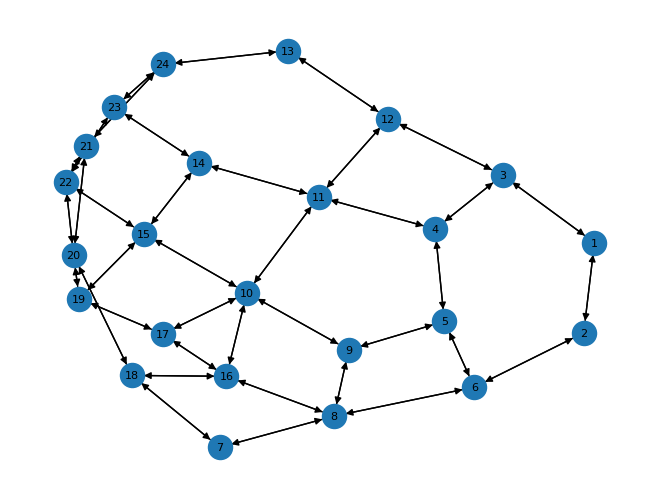

In [4]:
network = create_sioux_falls_network(network_path, costs_path)

nx.draw(network,
        with_labels=True,
        font_size=8,
        edgelist=[(v, w) for v, w in network.edges if v != w])

In [14]:
test = create_sioux_falls_cars(cars_path, network, 24 * 60, scaling=10)

In [19]:
test[1]

{1419: <Car 1419 (3 -> 10) at 1.0 of (3, 3)>,
 2663: <Car 2663 (4 -> 23) at 1.0 of (4, 4)>,
 3587: <Car 3587 (6 -> 8) at 1.0 of (6, 6)>,
 4391: <Car 4391 (7 -> 9) at 1.0 of (7, 7)>,
 4462: <Car 4462 (7 -> 10) at 1.0 of (7, 7)>,
 5296: <Car 5296 (7 -> 24) at 1.0 of (7, 7)>,
 5312: <Car 5312 (8 -> 1) at 1.0 of (8, 8)>,
 6101: <Car 6101 (8 -> 12) at 1.0 of (8, 8)>,
 6920: <Car 6920 (8 -> 23) at 1.0 of (8, 8)>,
 7160: <Car 7160 (9 -> 5) at 1.0 of (9, 9)>,
 9366: <Car 9366 (10 -> 8) at 1.0 of (10, 10)>,
 10786: <Car 10786 (10 -> 15) at 1.0 of (10, 10)>,
 13607: <Car 13607 (11 -> 9) at 1.0 of (11, 11)>,
 15040: <Car 15040 (11 -> 22) at 1.0 of (11, 11)>,
 15555: <Car 15555 (12 -> 7) at 1.0 of (12, 12)>,
 19504: <Car 19504 (14 -> 23) at 1.0 of (14, 14)>,
 20445: <Car 20445 (15 -> 11) at 1.0 of (15, 15)>,
 22015: <Car 22015 (16 -> 6) at 1.0 of (16, 16)>,
 24329: <Car 24329 (16 -> 24) at 1.0 of (16, 16)>,
 26399: <Car 26399 (17 -> 21) at 1.0 of (17, 17)>,
 27154: <Car 27154 (18 -> 22) at 1.0 of 

In [7]:
number_of_steps = 300
capacities = range(30, 50)

results2 = []
travel_times = []
for capacity in capacities:
    network = create_sioux_falls_network(network_path, costs_path, capacity=capacity, scaling=100)
    model = TrafficModel(network, create_sioux_falls_cars(cars_path, network, 300, scaling=20, seed=53), seed=53)
    h, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=True, return_step_statistics=True)
    results.append((h['latency'].max() - h['latency'].min()).mean())
    travel_times.append(car_stats_unrestricted['travel_time'].mean())

100%|██████████| 300/300 [03:44<00:00,  1.34it/s]


72000
21474


100%|██████████| 300/300 [03:42<00:00,  1.35it/s]


72000
20738


100%|██████████| 300/300 [04:06<00:00,  1.22it/s]


72000
20080


100%|██████████| 300/300 [04:03<00:00,  1.23it/s]


72000
19444


100%|██████████| 300/300 [04:00<00:00,  1.25it/s]


72000
18805


100%|██████████| 300/300 [04:03<00:00,  1.23it/s]


72000
18165


100%|██████████| 300/300 [04:06<00:00,  1.22it/s]


72000
17557


100%|██████████| 300/300 [03:44<00:00,  1.34it/s]


72000
16921


100%|██████████| 300/300 [03:52<00:00,  1.29it/s]


72000
16329


100%|██████████| 300/300 [03:44<00:00,  1.34it/s]


72000
15744


100%|██████████| 300/300 [03:45<00:00,  1.33it/s]


72000
15180


100%|██████████| 300/300 [03:48<00:00,  1.31it/s]


72000
14674


100%|██████████| 300/300 [03:49<00:00,  1.30it/s]


72000
14206


100%|██████████| 300/300 [03:49<00:00,  1.31it/s]


72000
13674


100%|██████████| 300/300 [03:48<00:00,  1.31it/s]


72000
13214


100%|██████████| 300/300 [04:00<00:00,  1.25it/s]


72000
12773


100%|██████████| 300/300 [04:09<00:00,  1.20it/s]


72000
12317


100%|██████████| 300/300 [04:09<00:00,  1.20it/s]


72000
11873


100%|██████████| 300/300 [03:59<00:00,  1.25it/s]


72000
11472


100%|██████████| 300/300 [03:48<00:00,  1.32it/s]


72000
11058


In [9]:
results

[3499.5283000278787,
 1791.8503500166116,
 1195.406300011366,
 893.3178750083634,
 707.5412400062164,
 581.7531500059148,
 495.40324286133614,
 425.42295000313527,
 370.807877780123,
 330.0343500010778,
 293.00085454620273,
 263.1026250003721,
 235.45956923105206,
 215.61324285732616,
 196.59187333342544,
 179.8914812499257,
 165.09258823535959,
 151.9333999999896,
 140.1567263154947,
 129.8145649995643,
 120.28381904690434,
 111.37404090845959,
 103.59231739051836,
 95.990620832386,
 89.89006799915788,
 64.28176999902614,
 59.907325805465526,
 56.317978124047485,
 52.87307575662112,
 49.64951176382966,
 46.73405999912861,
 43.80677777698969,
 41.080429728956226,
 38.65669473609765,
 36.24245384542415,
 34.08637749930442,
 31.889126828591937,
 30.002754761252266,
 28.20448372032644,
 26.57097954487886,
 24.9609333327928,
 23.503532608184223,
 22.16584468037921,
 20.865327082881546,
 19.633355101628776]

In [14]:
network = create_sioux_falls_network(network_path, costs_path, capacity=60, scaling=100)
model = TrafficModel(network, create_sioux_falls_cars(cars_path, network, 300, scaling=20, seed=54), seed=54)
h, car_stats_unrestricted = model.run_sequentially(300, show_progress=True, return_step_statistics=True)

100%|██████████| 300/300 [04:15<00:00,  1.17it/s]


72000
7449


In [15]:
pd.DataFrame([network.edges[edge]['latency_params'] for edge in network.edges]).describe()

,0,1,2,3
count,100.00000,100.000000,100.000000,100.0
mean,9.66000,14.284200,7.840000,1.0
std,6.65942,18.319452,3.863112,0.0
min,1.00000,0.000000,1.000000,1.0
25%,6.00000,0.030000,10.000000,1.0
50%,9.00000,1.920000,10.000000,1.0
75%,15.00000,30.030000,10.000000,1.0
max,30.00000,69.180000,10.000000,1.0


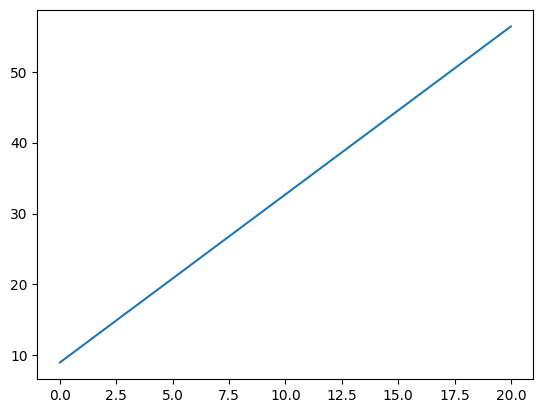

In [5]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0, 20, 0.01), network.edges[(21, 24)]['latency_fn'](np.arange(0, 20, 0.01)))
plt.show()

In [77]:
results

[1174305374.9054046,
 86619355.96439613,
 17479605.989031523,
 6160604.825417417,
 2262675.7798953787,
 661760.8763956778,
 170836.14924465012,
 2.6909928440708173,
 1.7179841420319448,
 1.2385638834458477,
 0.8750474572808197,
 0.6607149653415577,
 0.4821493613659305,
 0.412339721606897,
 0.34093252922271944,
 0.2718585087845137,
 0.21802227092288845,
 0.166776980580715]

In [53]:
flows = h['flow'].max().reset_index()
t = flows.apply(lambda x: x['index'][0] != x['index'][1], axis=1)
t

0      True
1      True
2     False
3      True
4      True
      ...  
95    False
96     True
97     True
98     True
99    False
Length: 100, dtype: bool

In [15]:
h['latency'].max() - h['latency'].min()

(1, 2)       0.023667
(1, 3)       0.017667
(1, 1)       0.000000
(2, 1)       0.013667
(2, 6)      40.539333
              ...    
(20, 20)     0.000000
(21, 20)    37.528667
(21, 22)     3.141167
(21, 24)    11.323333
(21, 21)     0.000000
Length: 100, dtype: float64

In [16]:
(h['latency'].max() - h['latency'].min()).mean()

10.45275666652158

In [30]:
network.edges[(21, 20)]['latency_fn'](0)

6.0

In [50]:
car_stats_unrestricted['travel_time'].mean()

70.35060602296322

In [17]:
network.edges

OutEdgeView([(1, 2), (1, 3), (1, 1), (2, 1), (2, 6), (2, 2), (3, 1), (3, 4), (3, 12), (3, 3), (6, 2), (6, 5), (6, 8), (6, 6), (4, 3), (4, 5), (4, 11), (4, 4), (12, 3), (12, 11), (12, 13), (12, 12), (5, 4), (5, 6), (5, 9), (5, 5), (11, 4), (11, 10), (11, 12), (11, 14), (11, 11), (9, 5), (9, 8), (9, 10), (9, 9), (8, 6), (8, 7), (8, 9), (8, 16), (8, 8), (7, 8), (7, 18), (7, 7), (18, 7), (18, 16), (18, 20), (18, 18), (16, 8), (16, 10), (16, 17), (16, 18), (16, 16), (10, 9), (10, 11), (10, 15), (10, 16), (10, 17), (10, 10), (15, 10), (15, 14), (15, 19), (15, 22), (15, 15), (17, 10), (17, 16), (17, 19), (17, 17), (14, 11), (14, 15), (14, 23), (14, 14), (13, 12), (13, 24), (13, 13), (24, 13), (24, 21), (24, 23), (24, 24), (23, 14), (23, 22), (23, 24), (23, 23), (19, 15), (19, 17), (19, 20), (19, 19), (22, 15), (22, 20), (22, 21), (22, 23), (22, 22), (20, 18), (20, 19), (20, 21), (20, 22), (20, 20), (21, 20), (21, 22), (21, 24), (21, 21)])

In [47]:
number_of_steps = 400

network = create_sioux_falls_network(network_path, costs_path)
model = TrafficModel(network, create_sioux_falls_cars(cars_path, network))
step_stats_unrestricted, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=True)

100%|██████████| 400/400 [01:17<00:00,  5.15it/s]


In [11]:
car_stats_unrestricted.set_index('step').tail()

,car_id,value_of_time,value_of_money,source,target,route,travel_time,toll,total_cost
step,,,,,,,,,
39,140384,1,1,24,21,"(24, 21, 21)",0,0.0,0.0
39,140385,1,1,24,21,"(24, 21, 21)",0,0.0,0.0
39,140386,1,1,24,21,"(24, 21, 21)",0,0.0,0.0
39,140387,1,1,24,21,"(24, 21, 21)",0,0.0,0.0
39,140399,1,1,24,23,"(24, 23, 23)",0,0.0,0.0


In [34]:
network.edges[(24, 21)]['latency_fn'](50) * 60

186.9562499556228

In [65]:
car_stats_unrestricted['travel_time'].mean()

11.867536231884058

In [57]:
number_of_steps = 400

network = create_sioux_falls_network(network_path, costs_path)
model = TrafficModel(network, create_sioux_falls_cars(cars_path, network), tolls=True, beta=4, R=2.500000e-05, seed=48)
step_stats_tolling, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=True)

100%|██████████| 400/400 [01:13<00:00,  5.41it/s]


In [58]:
car_stats_tolling['travel_time'].mean()

22.0675

In [32]:
len(car_stats_tolling)

3600

In [35]:
car_stats_unrestricted.groupby(['source', 'target'])['travel_time'].max()

source  target
1       2          1
        3          1
        4          2
        5          3
        6          9
                  ..
24      19        23
        20        13
        21         9
        22        11
        23         1
Name: travel_time, Length: 528, dtype: int64

In [42]:
len(car_stats_unrestricted)

3600

In [22]:
network.edges[(12,11)]['latency_fn'](2)

0.06024800000003936

In [9]:
network.edges[(10, 11)]['latency_fn'](8)

0.053072

In [5]:
from sklearn.model_selection import ParameterGrid
import numpy as np


number_of_steps = 450
seeds = [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

def evaluate(beta, R):
    run_results = []
    for seed in seeds:
        next_network = create_sioux_falls_network(network_path, costs_path)
        traffic_model = TrafficModel(next_network, create_sioux_falls_cars(cars_path, next_network),
                                     tolls=True, beta=beta, R=R, seed=seed)
        step_stats_tolled, car_stats_tolled = traffic_model.run_sequentially(number_of_steps, show_progress=True)
        run_results.append(car_stats_tolled["travel_time"].mean())
    return np.mean(run_results), np.mean(run_results)


res = []
for index, params in enumerate(ParameterGrid({
    'beta': [1.0, 2.0, 3.0, 4.0, 5.0],
    'R': [0.0, 0.00000001, 0.00000005, 0.0000001, 0.00000025, 0.0000005, 0.00000075, 0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075,
          0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
})):
    print(f'Evaluating {params} ({index})')
    travel_time, std = evaluate(**params)
    res.append({**params,
                'travel time': travel_time,
                'std': std})

  8%|▊         | 34/450 [00:11<02:22,  2.91it/s]


KeyboardInterrupt: 

In [6]:
optimization_results = pd.DataFrame(res)
optimization_results.sort_values(by='travel time') # 7.500000e-06 21.359083 2.0

,R,beta,travel time,std
51,0.000008,2.0,21.359083,21.359083
47,0.000005,3.0,21.359083,21.359083
65,0.000050,1.0,21.360694,21.360694
59,0.000010,5.0,21.362556,21.362556
61,0.000025,2.0,21.362778,21.362778
...,...,...,...,...
104,0.002500,5.0,23.148278,23.148278
118,0.010000,4.0,23.189528,23.189528
109,0.005000,5.0,23.282000,23.282000
114,0.007500,5.0,23.424556,23.424556


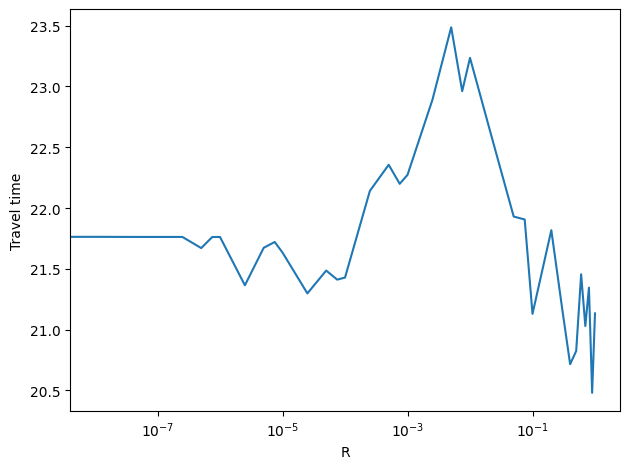

In [62]:
import matplotlib.pyplot as plt

ax = optimization_results[['R', 'travel time']].set_index('R').plot(legend=False)
ax.set_ylabel('Travel time')
ax.set_xscale('log')

plt.tight_layout()
ax.get_figure().savefig('R-optimization.pdf', dpi=300)

In [65]:
run_results = []
for seed in seeds:
    next_network = create_sioux_falls_network(network_path, costs_path)
    traffic_model = TrafficModel(next_network, create_sioux_falls_cars(cars_path, next_network), seed=seed)
    step_stats_not_restricted, car_stats_not_restricted = traffic_model.run_sequentially(number_of_steps, show_progress=True)
    run_results.append(car_stats_not_restricted["travel_time"].mean())
print(np.mean(run_results))
print(np.std(run_results))

100%|██████████| 400/400 [01:01<00:00,  6.50it/s]


21.40316666666667
0.4183139511519964


In [67]:
run_results = [
for seed in seeds:
    next_network = create_sioux_falls_network(network_path, costs_path)
    traffic_model = TrafficModel(next_network, create_sioux_falls_cars(cars_path, next_network), tolls=True, beta=4, R=1e-4, seed=seed)
    step_stats_not_restricted, car_stats_not_restricted = traffic_model.run_sequentially(number_of_steps, show_progress=True)
    run_results.append(car_stats_not_restricted["travel_time"].mean())
print(np.mean(run_results))
print(np.std(run_results))

100%|██████████| 400/400 [01:20<00:00,  4.97it/s]


21.53836111111111
0.45798489196198605


In [21]:
pd.read_pickle('test.pkl')

,edge,improvement
0,"(11, 4)",-0.086224


In [20]:
results = pd.DataFrame(columns=['edge', 'improvement'])
results = pd.concat([results, pd.DataFrame({
    'edge': [(0, 1)],
    'improvement': 0.9
})])
results

,edge,improvement
0,"(0, 1)",0.9
